In [1]:
# basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
# time it
import time

In [2]:
def read_datafiles(path):
    '''
    read and concat all files under the given path
    '''
    fileList = glob.glob(path+'*')
    df = pd.DataFrame()
    for f in fileList:
        df = pd.concat([df,pd.read_csv(f)], axis=0, ignore_index=True)
    return df

In [3]:
# read samples of train data
PATH_TO_TRAIN = '../data/train/'
train = read_datafiles(PATH_TO_TRAIN)

# read samples of dev data
PATH_TO_DEV = '../data/dev/'
dev = read_datafiles(PATH_TO_DEV)

# read samples of test data
PATH_TO_TEST = '../data/test/'
test = read_datafiles(PATH_TO_TEST)

## check classes uniformity of the 3 data sets

In [4]:
trainClasses = set(train.family_accession.unique())
devClasses = set(dev.family_accession.unique())
testClasses = set(test.family_accession.unique())

In [5]:
# train data vs dev data
print('nb classes in train\\dev:', len(trainClasses.difference(devClasses)))
print('nb classes in dev\\train:', len(devClasses.difference(trainClasses)))

nb classes in train\dev: 4858
nb classes in dev\train: 0


In [6]:
# train data vs test data
print('nb classes in train\\test:', len(trainClasses.difference(testClasses)))
print('nb classes in test\\train:', len(testClasses.difference(trainClasses)))

nb classes in train\test: 4858
nb classes in test\train: 0


In [7]:
onlyTrain = trainClasses.difference(devClasses)
nbRecordsOnlyTrain = train.loc[train.family_accession.isin(onlyTrain)].shape[0]
print('proportion of these classes in the train set: %.2f%%'%(100*nbRecordsOnlyTrain/train.shape[0]))

proportion of these classes in the train set: 2.01%


In [8]:
# classes in dev and test are identical
print('nb classes NOT IN the intersection of test and dev:',len(devClasses.symmetric_difference(testClasses)))

nb classes NOT IN the intersection of test and dev: 0


I could have proportionally re-distributed the classes only seen in the train set into the dev and test sets, but for simplicity and time saving, I just drop these classes from the training set

In [9]:
# drop classes from train ### could have been done in a more regorous way...
train = train.loc[~train.family_accession.isin(onlyTrain)]

In [10]:
# global helper list
aminoAcidList = ['A','R','N','D','C',
                 'Q','E','G','H','I',
                 'L','K','M','F','P',
                 'S','T','W','Y','V',
                 'X','U','B','O','Z','.']

The task is to classify a protein sequence, represented in strings, into protein families. The first challenge is to find meaningful numeric representation for the protein strings. 

To start simple, let's see what could be achieved by simple feature engineering on the sequence strings.

## EDA
For the exploratory data analysis, I mainly focus on the train data

One of the difficulties of this project comes from the huge number of possible classes, and it aggravates the non-uniformity of the distribution of the class population (here it's almost exponentially distributed). => Lack of domain knowledge, I will simply focus on the most populated classes who compose more than 50% of the training population. 

Should I have worked with experts of the portein domain, I might asked for help, for e.g., create meaningful hierarchical multi-labels in order to build models accordingly (simpler models for predicting the coarser classes, more developped models for refinig the subclasses).

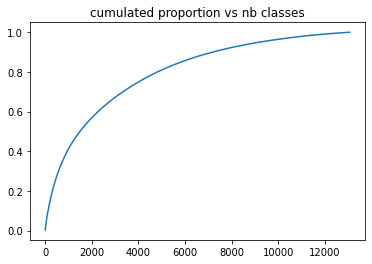

1487 classes represent more than a half of the training data.


In [11]:
# class occurence counts
countFreq = train.family_accession.value_counts()

# visualisaton of the classes' population
cumsum = countFreq.values.cumsum()
cumsumN = cumsum / cumsum.max()
plt.plot(cumsumN)
plt.title('cumulated proportion vs nb classes')
plt.show()
mostPopular = countFreq.index[:np.where(cumsumN>=0.5)[0][0]]
print("%d classes represent more than a half of the training data." % len(mostPopular))

In [12]:
# for simplicity, only the sufficiently populated classes are retained for the rest
# of the study
trainSub = train.loc[train.family_accession.isin(mostPopular)]

In [13]:
features = trainSub[['family_accession','sequence','aligned_sequence']]

In [14]:
features.shape

(532346, 3)

In [15]:
# length of the sequence and the aligned sequence
features.insert(features.shape[1], 'seqLen', value=features.sequence.apply(lambda x: len(x)).astype(np.uint16))
features.insert(features.shape[1], 'alignedSeqLen', value=features.aligned_sequence.apply(lambda x: len(x)).astype(np.uint16))

In [16]:
# proportion of each amino acid in the aligned sequence ("." included)
def get_proportion(seq, aminoAcid):
    return seq.count(aminoAcid)/len(seq)
for aminoAcid in aminoAcidList:
    features.insert(features.shape[1], 'proportion%s'%aminoAcid, value=features.aligned_sequence.apply(get_proportion,args=(aminoAcid,)).astype(np.float32))

In [17]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 532346 entries, 1 to 1086739
Data columns (total 31 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   family_accession  532346 non-null  object 
 1   sequence          532346 non-null  object 
 2   aligned_sequence  532346 non-null  object 
 3   seqLen            532346 non-null  uint16 
 4   alignedSeqLen     532346 non-null  uint16 
 5   proportionA       532346 non-null  float32
 6   proportionR       532346 non-null  float32
 7   proportionN       532346 non-null  float32
 8   proportionD       532346 non-null  float32
 9   proportionC       532346 non-null  float32
 10  proportionQ       532346 non-null  float32
 11  proportionE       532346 non-null  float32
 12  proportionG       532346 non-null  float32
 13  proportionH       532346 non-null  float32
 14  proportionI       532346 non-null  float32
 15  proportionL       532346 non-null  float32
 16  proportionK       5

In [18]:
# group the above dataframe "features" by class and compute the class avg and std
byFamily = features.groupby(by='family_accession').agg(['mean','std'])
# sort the aggregated dataframe by the class frequency (descending ordre in frequency)
byFamily = byFamily.loc[countFreq.index[:len(mostPopular)]]

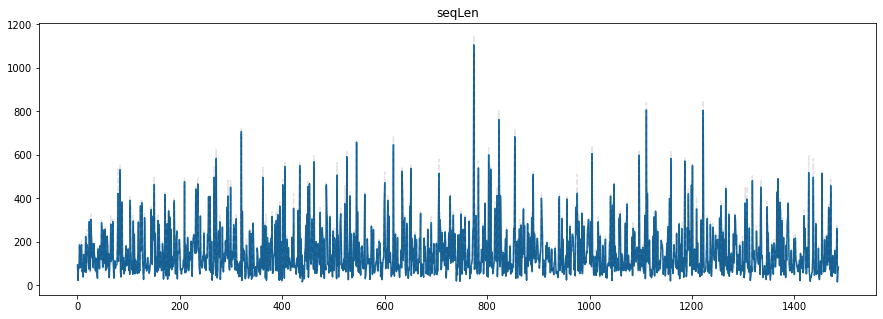

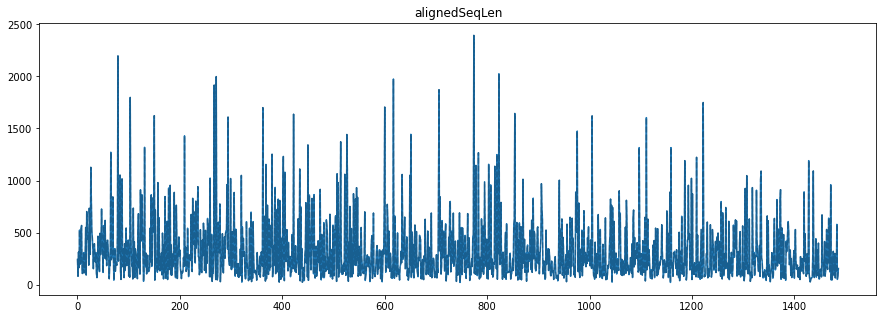

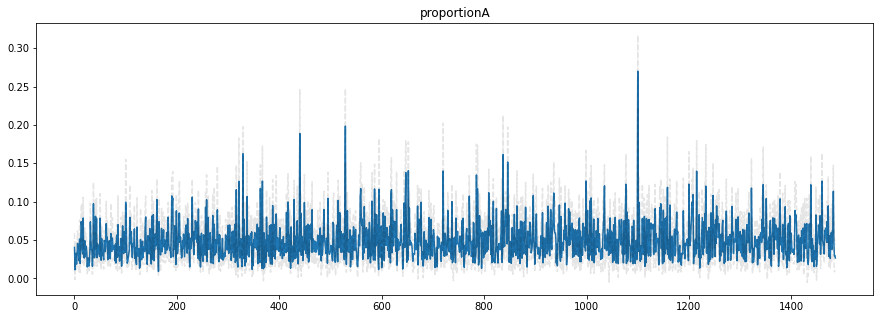

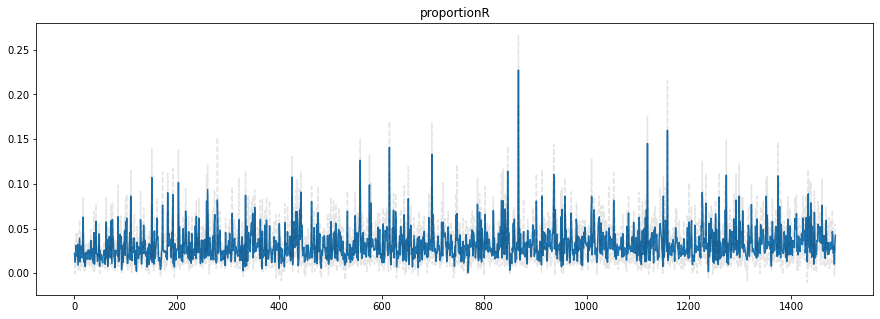

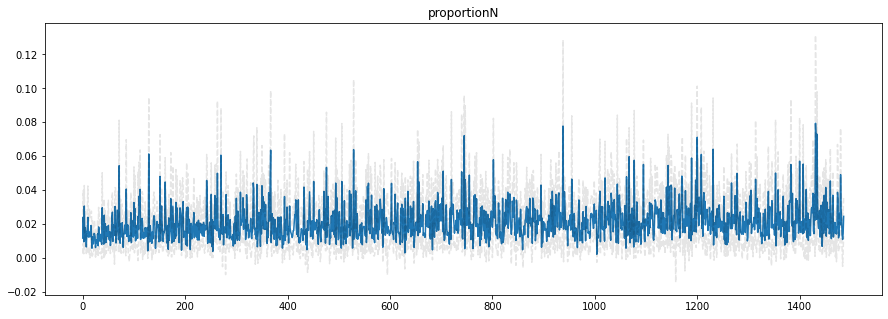

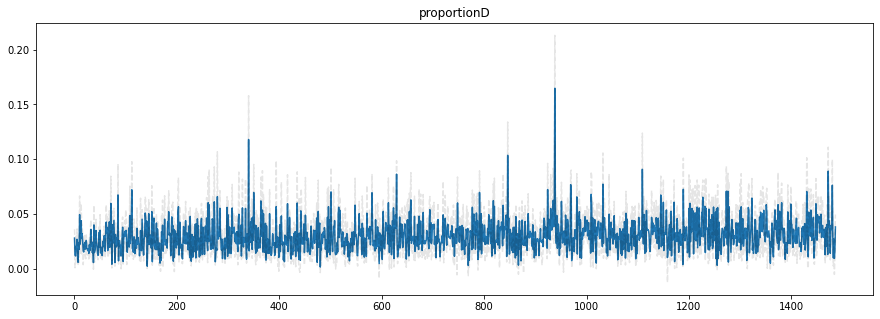

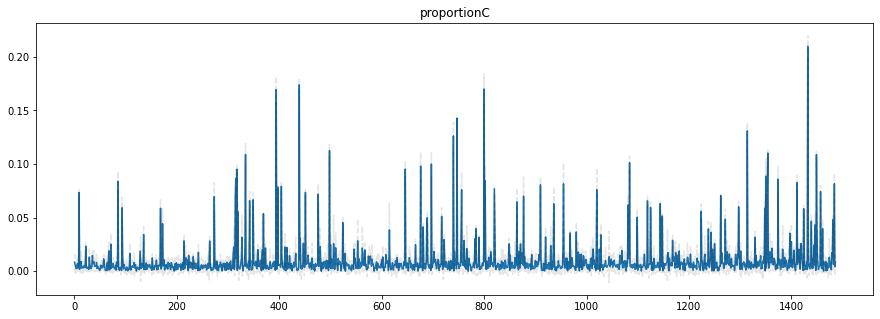

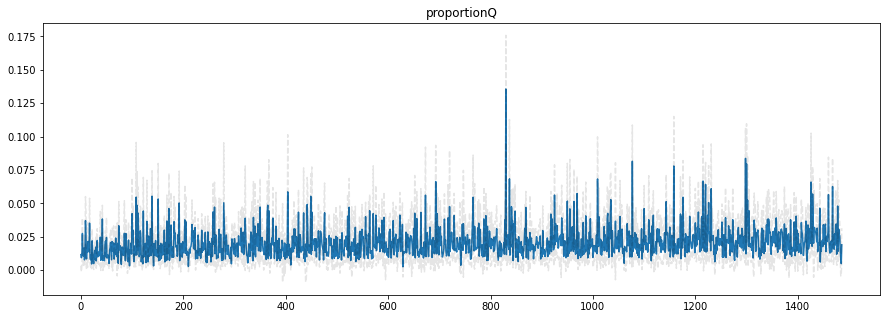

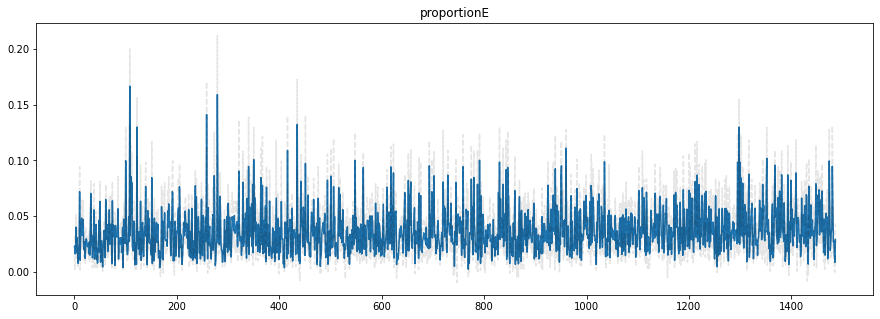

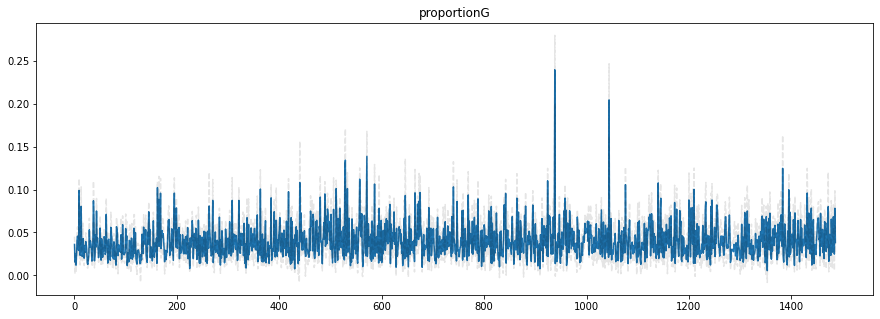

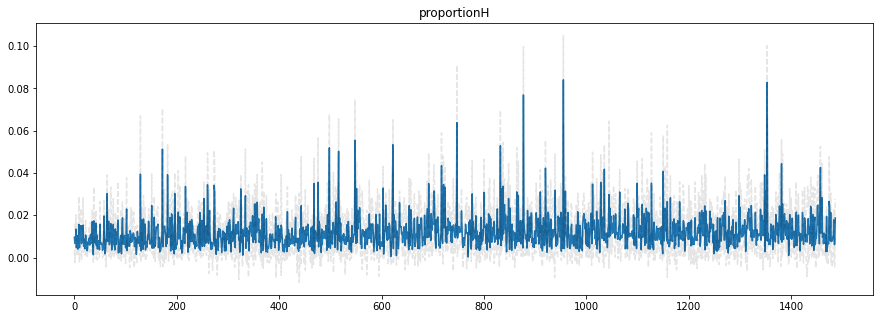

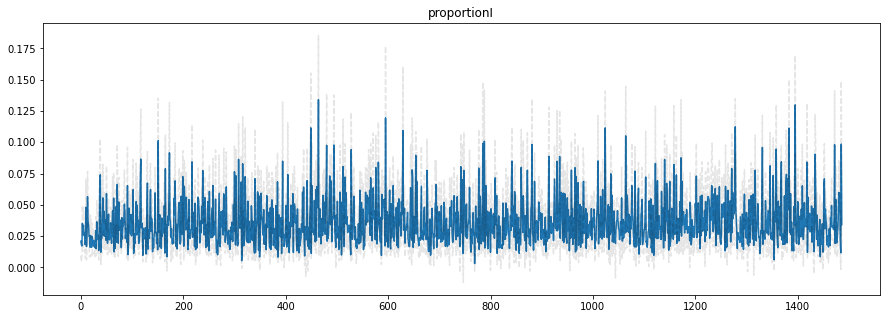

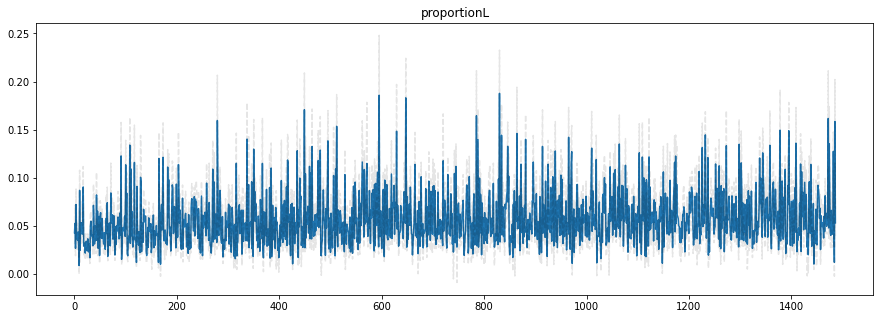

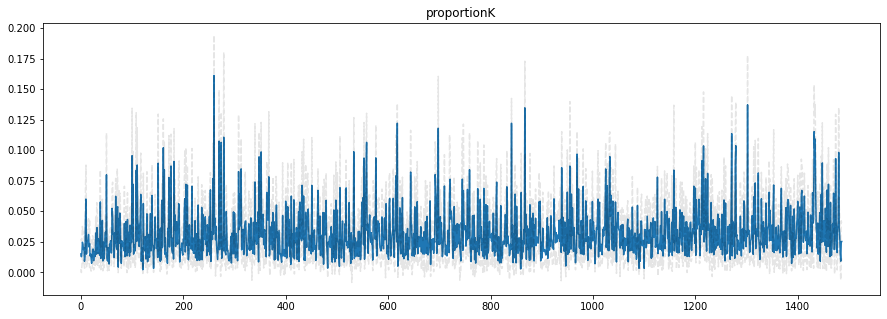

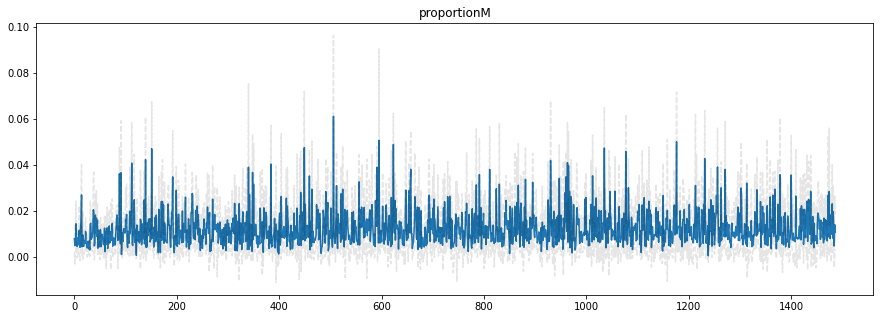

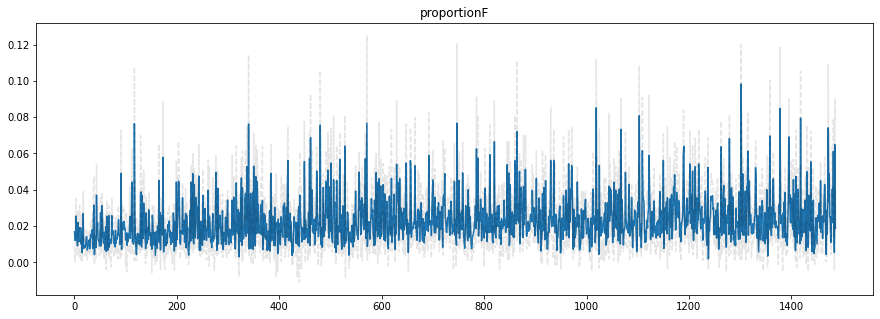

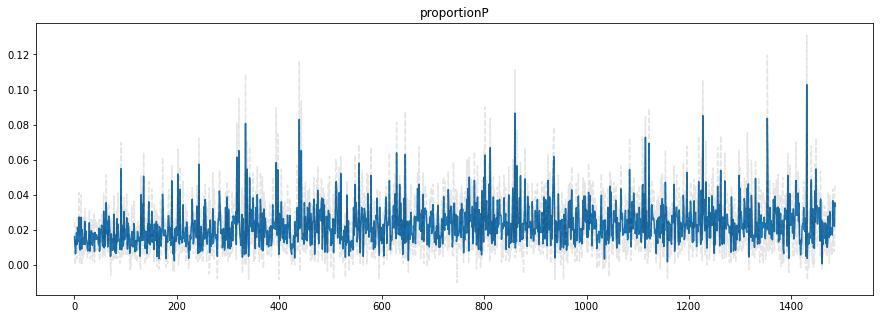

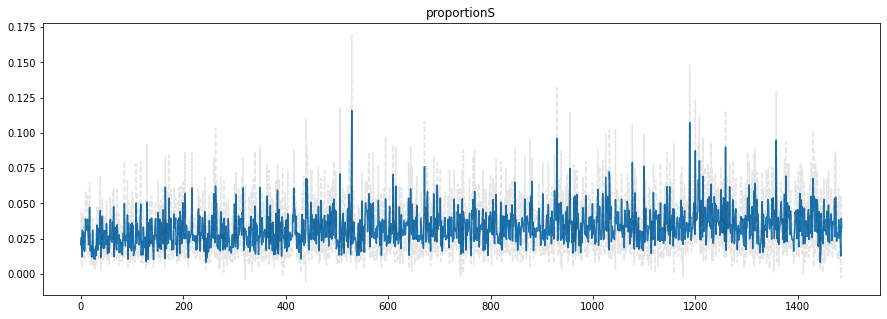

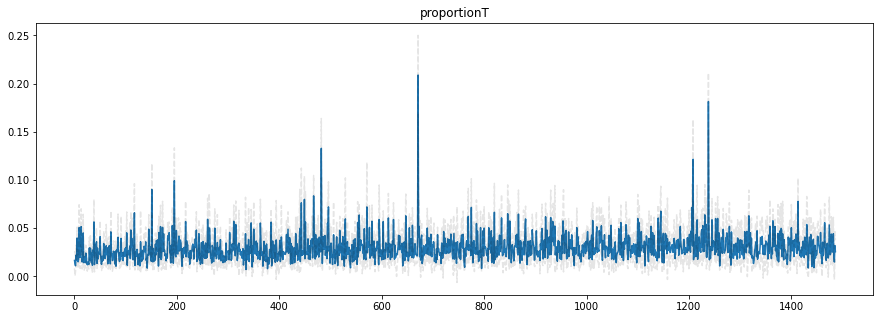

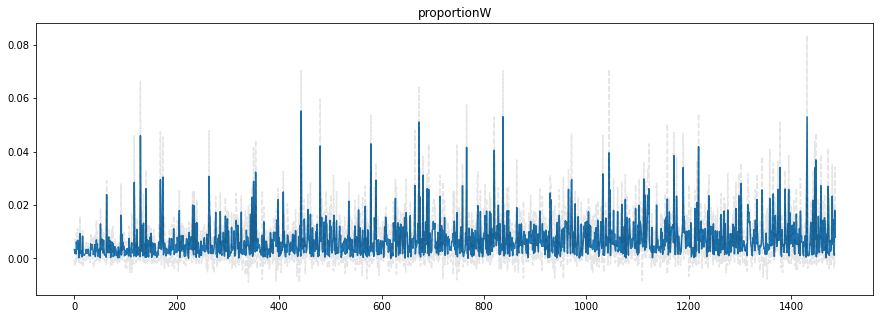

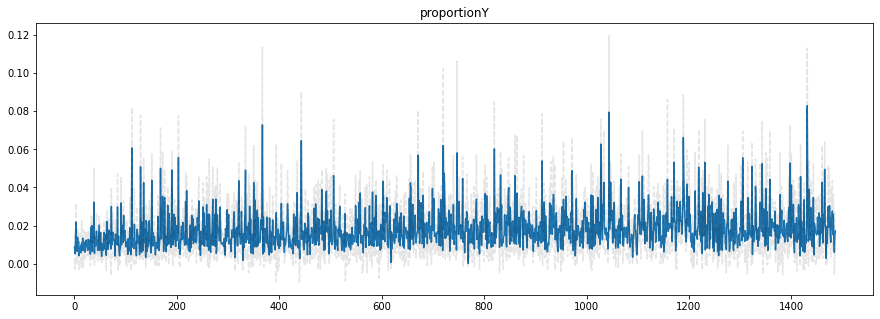

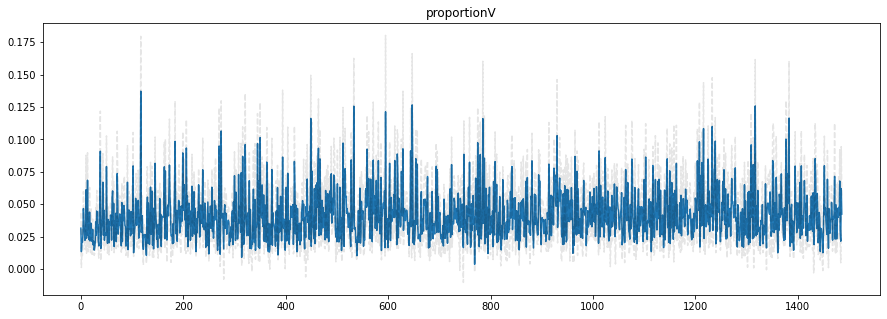

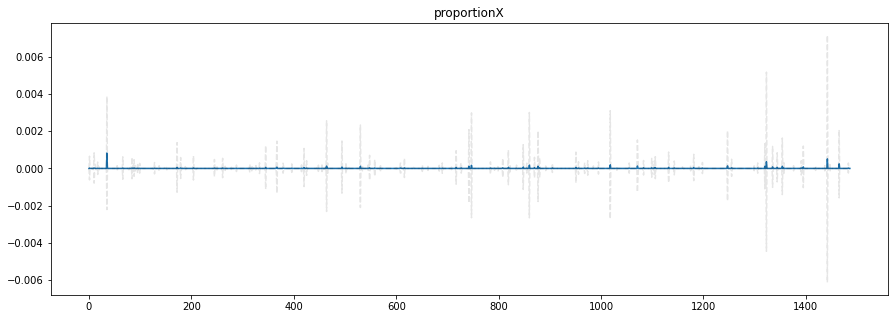

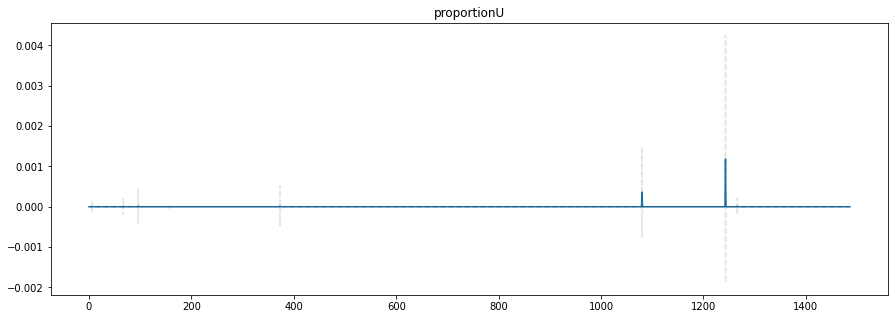

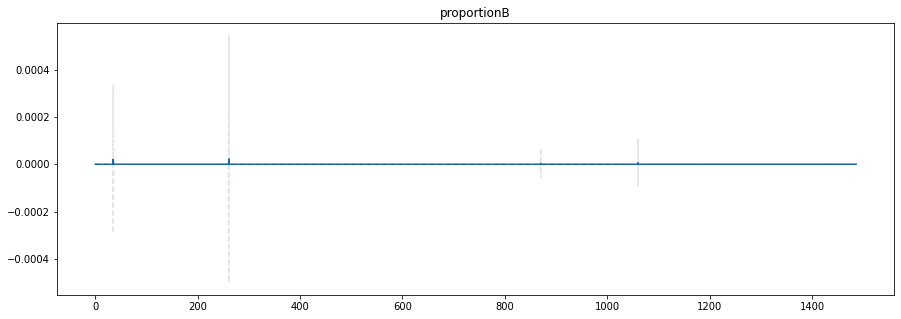

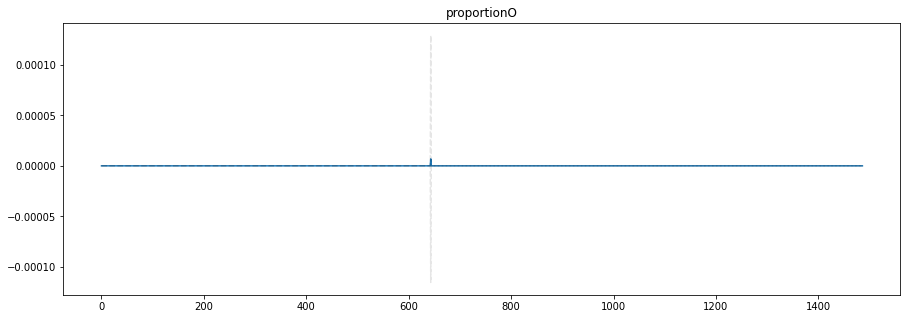

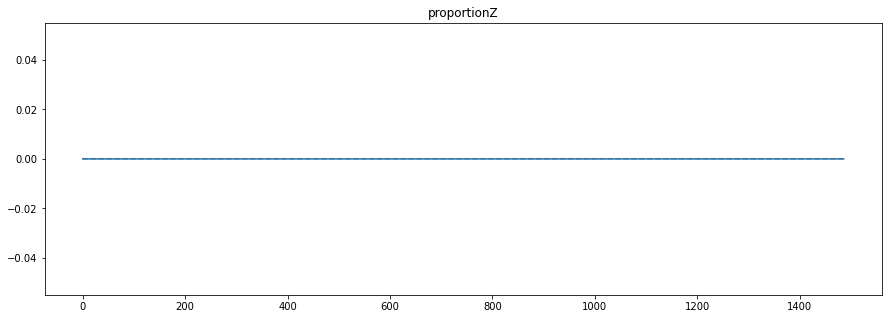

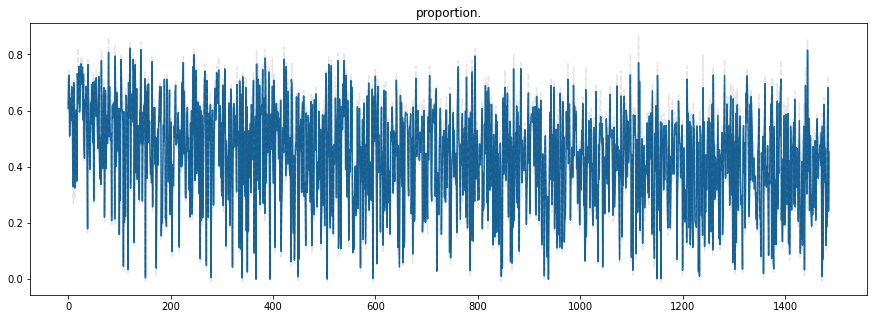

In [19]:
# a simple visualisation of the classes: class' mean and std of the above extracted features
for col in byFamily.columns.get_level_values(0)[::2]:
    plt.figure(figsize=(15,5))
    # plot mean +/- std of each feature
    plt.plot(byFamily[(col,'mean')].values)
    plt.plot(byFamily[(col,'mean')].values+byFamily[(col,'std')].values, 'k--', alpha=.1)
    plt.plot(byFamily[(col,'mean')].values-byFamily[(col,'std')].values, 'k--', alpha=.1)
    plt.title(col)
    plt.show()

It seems hard to conclude anything in general

### more on a single class

In [20]:
fam = countFreq.index[2]
singleClass = features.loc[features.family_accession==fam]

Markov chains perhaps? Will the (empirical) transition matrix of a given string be similar to that of the whole family's?

In [21]:
# empirically deduce the transition matrix of the amino acid of the class, compare it to
# the one deduced from a single sequence from that class.

def count_transitions(seq, transMat=None):
    global aminoAcidList 
    aminoAcidDict = {aa:i for i,aa in enumerate(aminoAcidList)}
    if transMat is None:
        transMat = np.zeros((len(aminoAcidList),len(aminoAcidList)))
    for i in range(len(seq)-1):
        transMat[aminoAcidDict[seq[i]],aminoAcidDict[seq[i+1]]] += 1
    return transMat 

def normalise_transition_matrix(transMat):
    return transMat /transMat.sum(axis=1).reshape(-1,1)

def compute_family_transition_matrix(subdf, col='aligned_sequence'):
    transMat = count_transitions(subdf[col].iloc[0])
    for seq in subdf[col].iloc[1:]:
        transMat = count_transitions(seq, transMat)
    return normalise_transition_matrix(transMat)

def plot_transition_matrix(transMat):
    global aminoAcidList
    plt.figure(figsize=(12,10))
    plt.imshow(transMat)
    plt.xticks(ticks=np.arange(transMat.shape[0]), labels=aminoAcidList)
    plt.yticks(ticks=np.arange(transMat.shape[0]), labels=aminoAcidList)
    plt.colorbar()
    plt.show()

<ipython-input-21-281878ac88fb>:14: RuntimeWarning: invalid value encountered in true_divide
  return transMat /transMat.sum(axis=1).reshape(-1,1)


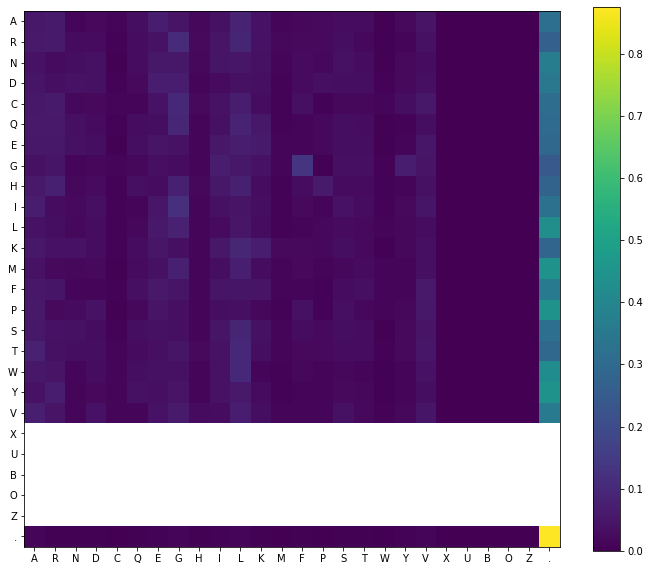

In [22]:
transMatClass = compute_family_transition_matrix(singleClass)
plot_transition_matrix(transMatClass)

<ipython-input-21-281878ac88fb>:14: RuntimeWarning: invalid value encountered in true_divide
  return transMat /transMat.sum(axis=1).reshape(-1,1)


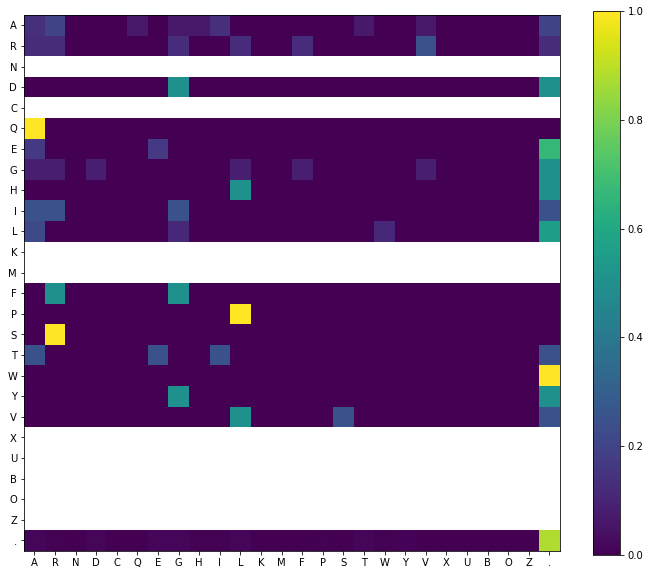

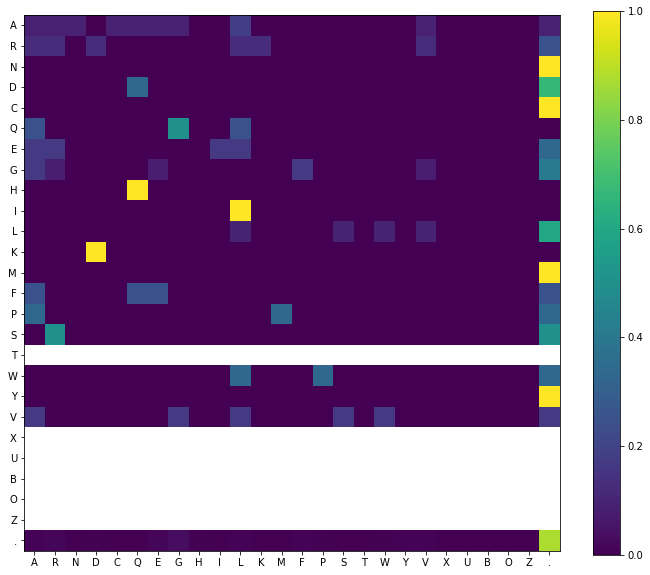

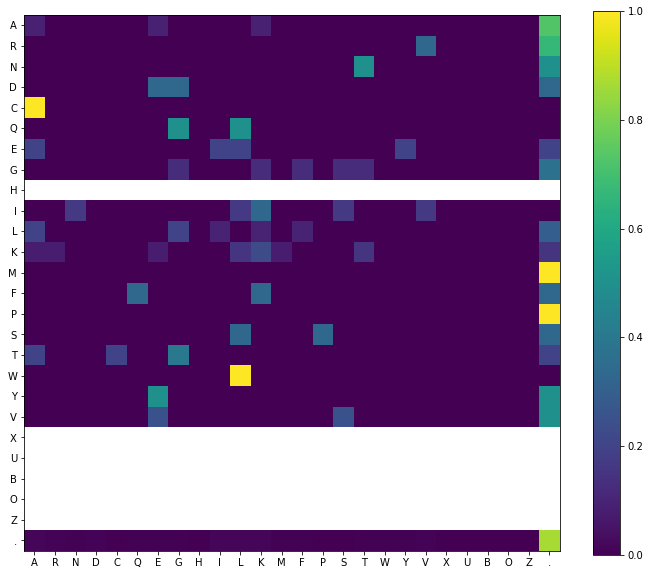

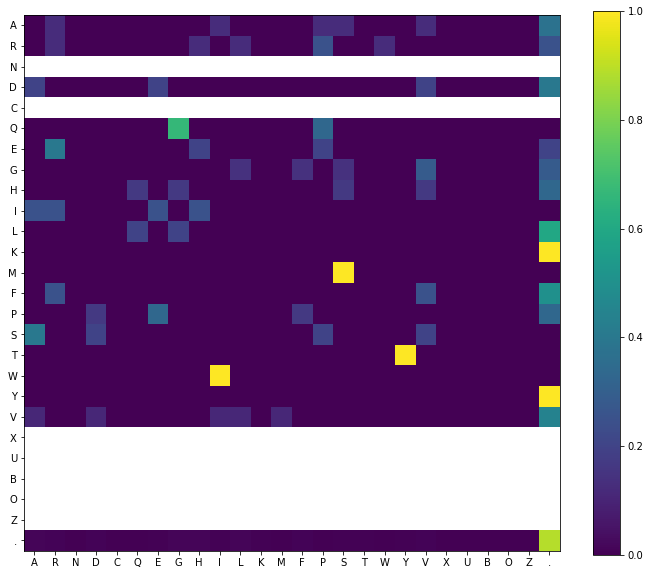

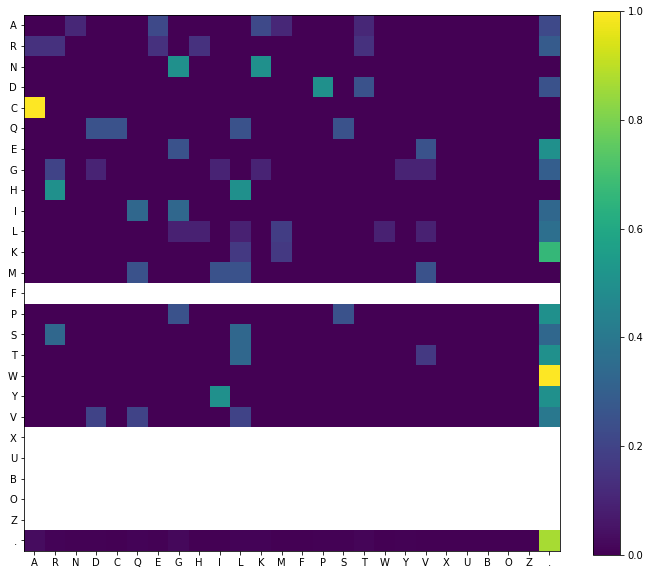

In [23]:
# randomly sample some aligned sequences from the same class and plot their trans mat
for idx in np.random.choice(np.arange(singleClass.shape[0]), size=5, replace=False):
    print('===========================')
    transMatSingle = count_transitions(singleClass.aligned_sequence.iloc[idx])
    transMatSingle = normalise_transition_matrix(transMatSingle)
    plot_transition_matrix(transMatSingle)

it seems that comparing single sequence's transition matrix to the family's transition matrix does not give promising results... Plus it would be quite costly even if it does: 10K classes would require 10K 25x25 matrices.

What if I don't care about which amino acid it is at each position, but only care about whether there is an identified / aligned amino acid? That converts the aligned sequence to a binary sequence.

In [24]:
def convert_to_bin(seq):
    '''
    return a binary vector of the same length as seq, res[i] = 0 if seq[i] is "."; 1 otherwise
    '''
    # result vect to be returned, of the same length as the input sequence
    res = np.zeros(len(seq),dtype=bool)
    for i in range(len(seq)):
        res[i] = (seq[i] != '.')
    return res

def get_binarised_mat(subdf, colSeq='aligned_sequence'):
    '''
    stack the binary vector of each sequence to get a binary matrix
    this helps to visualise pattern of a bunch of sequences
    '''
    mat = np.zeros((subdf.shape[0],len(subdf[colSeq].iloc[0])), dtype=bool)
    for i in range(subdf.shape[0]):
        mat[i] = convert_to_bin(subdf[colSeq].iloc[i])
    return mat

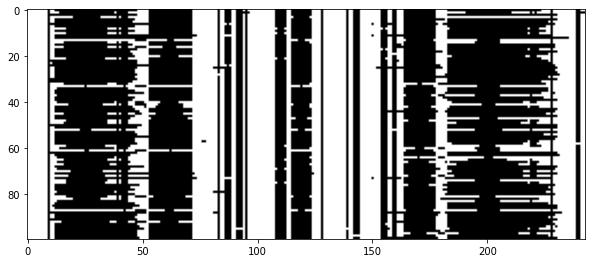

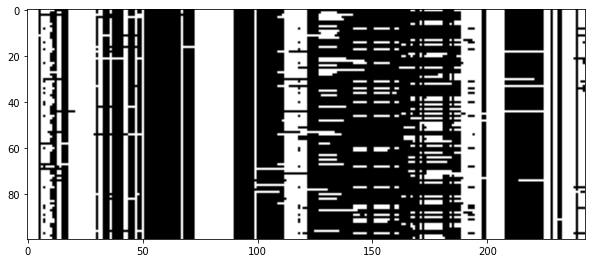

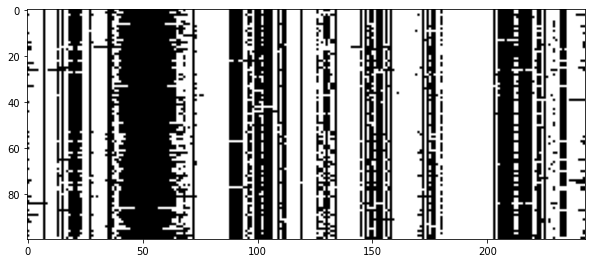

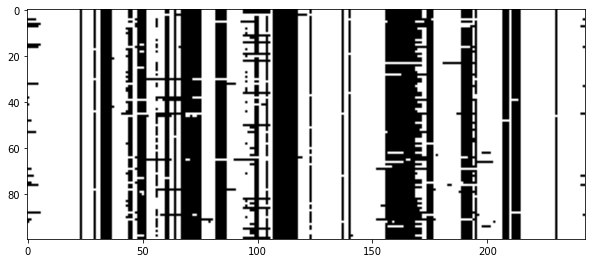

In [25]:
# let's see if there are some patterns in the aligned sequences that characterise a family
# 1. binarise the aligend seuqnce: '.' = 0 and 1 otherwise
# 2. stack all binarise sequences of the same protein family and plot the matrix
# Several protein families have the same aligned sequence length, for illustration I choose
# those having a length of N and select at most 100 family members to plot.
for fam in features.loc[(features.alignedSeqLen==243),'family_accession'].unique():
    mat = get_binarised_mat(features.loc[features.family_accession==fam])
    plt.figure(figsize=(10,10))
    if mat.shape[0] > 100:
        # randomly choose 100 sequence for visualising
        idx = np.random.choice(np.arange(mat.shape[0]), size=100, replace=False)
    else:
        idx = np.arange(mat.shape[0])
    plt.imshow(mat[idx,:],'gray')
    plt.show()

these "bar code"-like plots are interesting, they show that we might exepct some patterns unique to each family (gap or not + where to gap). Let's try to encode this information.

For e.g., I want to encode the string "AC..R" to the corresponding binary sequence "11001" then I can numerise the string to an integer number: bin2deci(11001) = 25. Suppose I'm given a new string "AB..." and this one is of the same family as the first one, by the computation I will have it encoded to 24, which is close enough to the first value.

Problem is that if the sequence gets longer and longer, simple conversion will result in overfloat => a possible solution: segement the given long sequence into several pieces and encode each piece sepereately. Working with a machine of 64bit, I choose to segment the sequence by 64 characters max, so each segment is represented by a uint64. A sequence is then encoded by a vector of such integers. For shorter sequences, I use 0-padding to match the length of the vectors of longer sequences.

The hope is that for sequences within a same family, the member encoding vectors stay relatively similar.

In [26]:
# encode the binary pattern
# get the length of the longest possible aligned sequence
maxLen = features.alignedSeqLen.max() 
# maximum length of a segment of a sequence
# 64 because my pc is an 64bit machine, the max uint "affordable" is then 2**64-1
segmentSize = 64
# number of segments per sequence
# for short(er) sequences, use 0 padding
segmentNb = maxLen // segmentSize + 1

def encode_sequence_by_segment(seq, start, end, segmentSize):
    '''
    numerise the segment of the given sequence seq[start:end] by binary encoding.
    '''
    value = 0
    for i, c in enumerate(seq[start:end]):
        # if NOT gapped
        if c != '.':
            # (1 << n) := move "1" towards the left by n bits = 2**n
            # (x |= y) := conduct "|" (OR operation) bitwise between x and y and update x in place
            value |= 1 << (segmentSize-1-i)
    # out of for-loop
    # the loop creates a binary representation of a given segment computed on gaps, so the bin 
    # representation integrates the gap information; it then converts the binary representation 
    # to an unsigned integer, numerising the segment from string.
    return value

In [27]:
bitMask = trainSub[['family_accession','aligned_sequence']]
# apply the above defined encoding function to all the sequences
for i in range(segmentNb):
    vals = bitMask.aligned_sequence.apply(encode_sequence_by_segment,
                                          args=(i*segmentSize, (i+1)*segmentSize, segmentSize))
    bitMask.insert(loc=bitMask.shape[1],column='seg%d'%i, value=vals)

In [28]:
bitMask.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 532346 entries, 1 to 1086739
Data columns (total 40 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   family_accession  532346 non-null  object
 1   aligned_sequence  532346 non-null  object
 2   seg0              532346 non-null  uint64
 3   seg1              532346 non-null  uint64
 4   seg2              532346 non-null  uint64
 5   seg3              532346 non-null  uint64
 6   seg4              532346 non-null  uint64
 7   seg5              532346 non-null  uint64
 8   seg6              532346 non-null  uint64
 9   seg7              532346 non-null  uint64
 10  seg8              532346 non-null  uint64
 11  seg9              532346 non-null  uint64
 12  seg10             532346 non-null  uint64
 13  seg11             532346 non-null  uint64
 14  seg12             532346 non-null  uint64
 15  seg13             532346 non-null  uint64
 16  seg14             532346 non-null  ui

## Classification

In [29]:
# the training model does not need to be too complexe if the feature space is properly 
# "created" 
from sklearn.ensemble import RandomForestClassifier

In [30]:
testSub = test.loc[test.family_accession.isin(mostPopular)]
devSub = dev.loc[dev.family_accession.isin(mostPopular)]

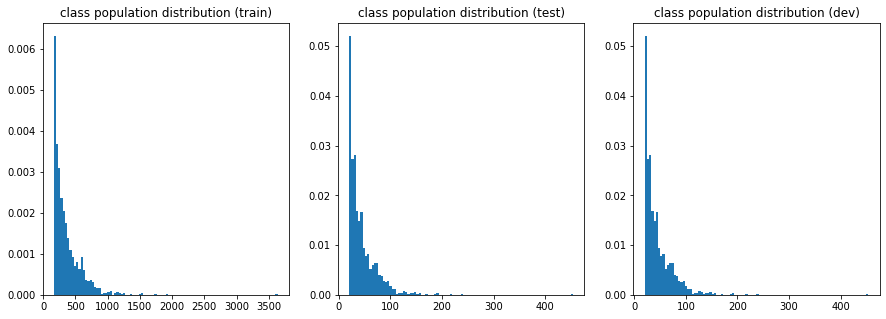

In [31]:
countFreqTr = trainSub.family_accession.value_counts()
countFreqTs = testSub.family_accession.value_counts()
countFreqDv = devSub.family_accession.value_counts()
fig,axes = plt.subplots(ncols=3,nrows=1,figsize=(15,5))
axes[0].hist(countFreqTr, bins=100, density=True)
axes[0].set_title('class population distribution (train)')
axes[1].hist(countFreqTs, bins=100, density=True)
axes[1].set_title('class population distribution (test)')
axes[2].hist(countFreqDv, bins=100, density=True)
axes[2].set_title('class population distribution (dev)')
plt.show()

Unbalanced population distribution...

In [33]:
# process the test and dev data sets in the same way as the train set

## test
bitMaskTest = testSub[['family_accession','aligned_sequence']]
for i in range(segmentNb):
    vals = bitMaskTest.aligned_sequence.apply(encode_sequence_by_segment,
                                              args=(i*segmentSize, (i+1)*segmentSize, segmentSize))
    bitMaskTest.insert(loc=bitMaskTest.shape[1],column='seg%d'%i, value=vals)

## dev
bitMaskDev = devSub[['family_accession','aligned_sequence']]
for i in range(segmentNb):
    vals = bitMaskDev.aligned_sequence.apply(encode_sequence_by_segment,
                                              args=(i*segmentSize, (i+1)*segmentSize, segmentSize))
    bitMaskDev.insert(loc=bitMaskDev.shape[1],column='seg%d'%i, value=vals)

In [34]:
bitMask.head()

,family_accession,aligned_sequence,seg0,seg1,seg2,seg3,seg4,seg5,seg6,seg7,...,seg28,seg29,seg30,seg31,seg32,seg33,seg34,seg35,seg36,seg37
1,PF08512.12,AGVPCSVKA...SEGYLFPL......DRCFLF.VTKPTLYIPYSE....,18415201556861812767,18032553628299952128,424359881342912,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,PF01455.18,MCIAIPGR...I.ER..IDY...............P....IAIVDF...,18381002074746653823,13835148214832987648,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,PF12673.7,NIFHI..LWEDVDL..E.GVTFKPMG...E...........S.......,18013483458113839099,9223372105305874552,270224367216098784,6953610601218179072,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,PF17765.1,VSPILQSLLDQLE..TTPAYILDQRMNIVGWNEAFSDVYGD........,18445055223840900080,441336022085910631,18437103545011240832,17966886767443967,15996785876420001792,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,PF13959.6,ITRNAESLCASDVTLKQFAQRAFVSYLK............SVGMNK...,18446744005006786678,2088684995961946112,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


For the moment, tuning hyper-parametres is not on my priority list, so I left the default settings. But if given more resources (time, teamwork, domain knowledge...), this indeed can be greatly improved by cross validation and/or automatic hyper-parametre tuning methods.

In [35]:
rfBit = RandomForestClassifier()
for _ in range(3):
    print('-------------------------')
    # randomly pick a third of the training population for model fitting
    # prevent program from crashing due to little memory
    idx = np.random.choice(np.arange(bitMask.shape[0]), size=bitMask.shape[0]//3, replace=False)
    tt = time.time()
    rfBit.fit(bitMask.iloc[idx,2:], bitMask.iloc[idx,0])
    print("Model fitted in %.2f seconds" % (time.time()-tt))
    print('testing...')
    tt = time.time()
    # lazy evaluation: mean accuracy of all top populated classes mixed up
    devScore = rfBit.score(bitMaskDev.iloc[:,2:], bitMaskDev.iloc[:,0])
    testScore = rfBit.score(bitMaskTest.iloc[:,2:], bitMaskTest.iloc[:,0])
    print("tests done in %.2f seconds" % (time.time()-tt))
    print('score on dev:', devScore)
    print('score on test:', testScore)
    

-------------------------
Model fitted in 139.41 seconds
testing...
tests done in 164.28 seconds
score on dev: 0.9728203801494423
score on test: 0.9721507814521161
-------------------------
Model fitted in 144.08 seconds
testing...
tests done in 172.77 seconds
score on dev: 0.9728508164538662
score on test: 0.9724247081919314
-------------------------
Model fitted in 141.30 seconds
testing...
tests done in 167.88 seconds
score on dev: 0.9727138530839585
score on test: 0.9722877448220237


I'm happy with the results above, with minimal information the model achieves a rather high accuracy in general. Yet I'm aware of the bias behind the avg accuracy that is shown above, including ignoring possible poor performance on minority classes and assuming all classes have the same weight, etc. 

Possible improvements to the above study other than tuning more carefully the model's hyper-parametres, could be 

1. combinging informative features from both dataframes (proportion information + binarised gap information). Domain knowledge about the protein sequences might be able to tell whether some amino acids' proportion is important for knowing the protein's functions, and thus help select some features from the proportion dataframe to enrich the encoding dataframe.

2. instead of binary encoding, which leaves out some potential noise but also retaining only minimal amount of information, usage of N-base encoding (=> sequence segmentation with smaller granularity than 64) might bring in more valuable information. Again this would need domain knowledge to tell whether it is reasonable to group up some of the amino acids.

### stand-by 

In [ ]:
# process the test and dev data sets in the same way as the train set

## test
featuresTest = testSub[['family_accession','sequence','aligned_sequence']]
# length of the sequence and the aligned sequence
featuresTest.insert(featuresTest.shape[1], 'seqLen', value=featuresTest.sequence.apply(lambda x: len(x)).astype(np.uint16))
featuresTest.insert(featuresTest.shape[1], 'alignedSeqLen', value=featuresTest.aligned_sequence.apply(lambda x: len(x)).astype(np.uint16))
# proportion of each amino acid in the aligned sequence ("." included)
for aminoAcid in aminoAcidList:
    featuresTest.insert(featuresTest.shape[1], 'proportion%s'%aminoAcid, value=featuresTest.aligned_sequence.apply(get_proportion,args=(aminoAcid,)).astype(np.float32))
    
## dev
featuresDev = devSub[['family_accession','sequence','aligned_sequence']]
# length of the sequence and the aligned sequence
featuresDev.insert(featuresDev.shape[1], 'seqLen', value=featuresDev.sequence.apply(lambda x: len(x)).astype(np.uint16))
featuresDev.insert(featuresDev.shape[1], 'alignedSeqLen', value=featuresDev.aligned_sequence.apply(lambda x: len(x)).astype(np.uint16))
# proportion of each amino acid in the aligned sequence ("." included)
for aminoAcid in aminoAcidList:
    featuresDev.insert(featuresDev.shape[1], 'proportion%s'%aminoAcid, value=featuresDev.aligned_sequence.apply(get_proportion,args=(aminoAcid,)).astype(np.float32))

In [ ]:
featuresTest.head()

In [ ]:
# the following code kills the kernel. 
# might be due to bad seperation of the feature space (little information gain at each step when
# growing the trees?)
rfFeature = RandomForestClassifier()
for _ in range(3):
    print('-------------------------')
    # randomly pick a fifth of the training population for model fitting
    # prevent program from crashing due to little memory left...
    idx = np.random.choice(np.arange(features.shape[0]), size=features.shape[0]//5, replace=False)
    tt = time.time()
    # here the column "proportion." is left out since all propotions sum up to 1
    rfFeature.fit(features.iloc[idx,3:-1], features.iloc[idx,0])
    print("Model fitted in %.2f seconds" % (time.time()-tt))
    print('testing...')
    tt = time.time()
    # lazy evaluation: mean accuracy of all top populated classes mixed up
    devScore = rfFeature.score(featuresDev.iloc[:,3:-1], featuresDev.iloc[:,0]) 
    testScore = rfFeature.score(featuresTest.iloc[:,3:-1], featuresTest.iloc[:,0])
    print("tests done in %.2f seconds" % (time.time()-tt))
    print('score on dev:', devScore)
    print('score on test:', testScore)
    

-------------------------
